# Calculate buoyancy frequency profiles, WKB limit and ultimately vertical modes

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta
# import filtering
import numpy as np
import dask
from dask.distributed import Client,default_client
import xrft


def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

<Client: 'tcp://127.0.0.1:45609' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45609,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:39777,Total threads: 4
Dashboard: /proxy/33043/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41503,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [48]:
data = tt.collect_data(exptname="full-20",rawdata = ["rho","u"],timerange = (38000 - 10,38000 + 10)).sel(yb = slice(-5,5),xb = slice(700,705)).load()


loading rho...	done.
loading u...	done.


In [49]:
def calculate_N(rho):
    """
    Calculate the buoyancy frequency given density rho in z* coords"""
    N = np.sqrt(
        ((9.8 / rho) * rho.differentiate("zl"))
        ).rename("N")
    N.attrs = {"units":"s^-1"}
    return N



## Calculate the vertical modes

$ \huge \phi_n = \sqrt{\frac{2N}{h\overline{N}}} \cos{\int^z_{-H}} \frac{N(z)}{c_n} dz' $

$ \huge c_n = \frac{h \overline{N}}{n \pi} $

$ \huge u_n(x,y,z,t) = \int^0_H u \phi_n dz$


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


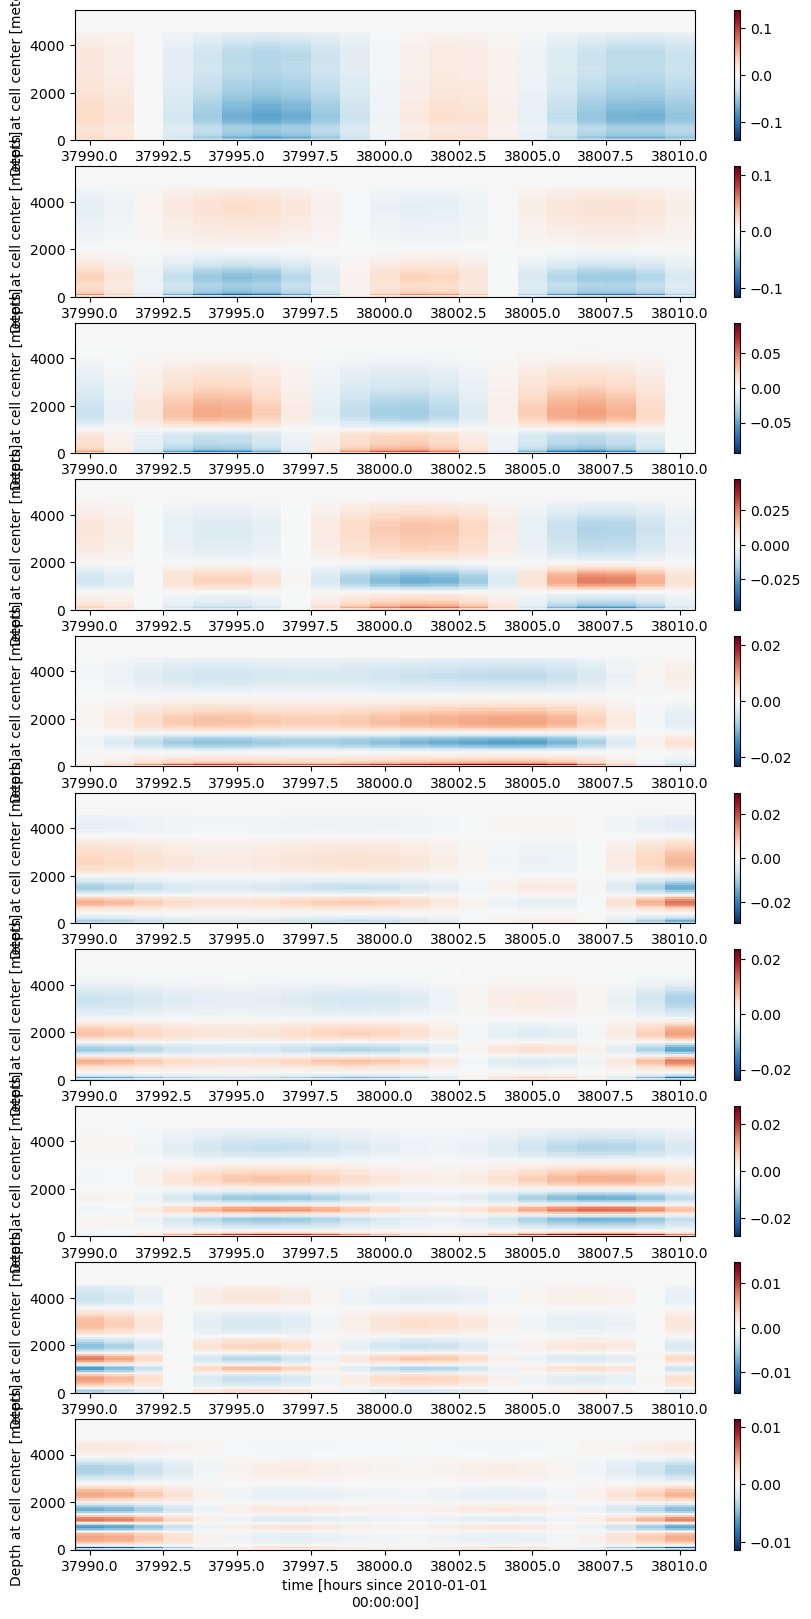

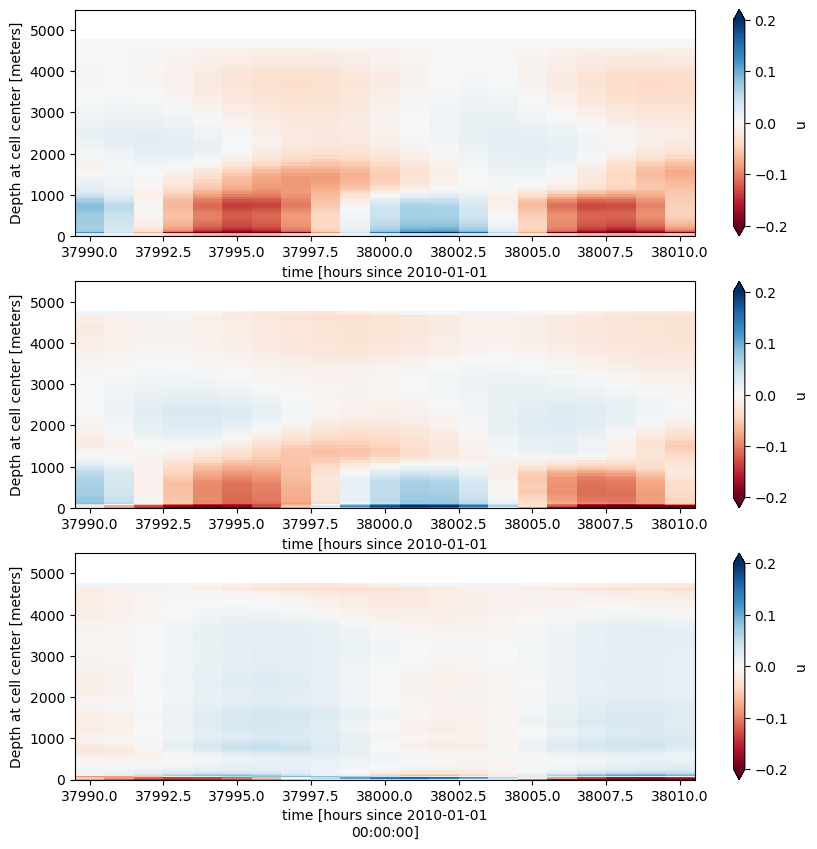

In [52]:
import scipy

def VerticalModes(data):
    H = np.abs(data.bathy.mean("xb").mean("yb")).values
    N = calculate_N(data.rho).mean("time").mean("xb").mean("yb")

    modes = {}
    for n in range(10):
        Nbar = N.mean("zl")
        c_n = H * Nbar / (np.pi * n)

        integrated = (N * 0) + scipy.integrate.cumulative_trapezoid(
            (n * N * np.pi) / (H * Nbar),x = data.zl.values,
            initial = 0)
        phi_n = (np.sqrt(
            2 * N / (H * N.mean("zl"))
        ) * np.cos(
            integrated
        )).fillna(0)

        modes[n] = (data.u.fillna(0) * phi_n).integrate("zl") * phi_n

    return modes

modes = VerticalModes(data)

total = data.u.mean("xb").mean("yb") * 0

fig,ax = plt.subplots(10,figsize = (10,20))
for i in range(0,10):
    modes[i].mean("xb").mean("yb").plot(ax = ax[i],x = "time")
    total += modes[i].mean("xb").mean("yb")

fig,ax = plt.subplots(3,figsize = (10,10))
total.plot(ax = ax[0],x = "time",vmax = 0.2,vmin = -0.2,cmap = "RdBu")
data.u.mean("xb").mean("yb").plot(ax = ax[1],x = "time",vmax = 0.2,vmin = -0.2,cmap = "RdBu")
(data.u.mean("xb").mean("yb") - total).plot(ax = ax[2],x = "time",vmax = 0.2,vmin = -0.2,cmap = "RdBu")

